<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/05-dl-autonomous-vehicle/dl_autonomous_vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [ ]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

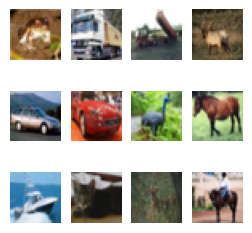

In [ ]:
# Number of rows and columns in the grid of subplots
num_rows = 3
num_cols = 4
# Total number of images to display (grid size)
num_images = num_rows * num_cols

# Create a figure and a grid (array) of subplots with the specified size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(3, 3))

# Flatten the 2D array of axes to a 1D array for easy iteration
axes = axes.flatten()

# Loop through each subplot and display the corresponding image
for i in range(num_images):
  # Show the i-th image in the flattened axes array
  axes[i].imshow(x_train[i, :, :])  # Show the i-th image in the flattened axes array
  # Hide the axis labels and ticks for a cleaner look
  axes[i].axis('off')

plt.show()

#Dataset Preprocessing

In [ ]:
# normalize images to the range [0, 1].
x_train_norm = x_train.astype("float32") / 255
x_test_norm  = x_test.astype("float32") / 255

In [ ]:
# flattening from (n,1) to (n,)
y_train = y_train.flatten()
y_test = y_test.flatten()

# separeting classes
animals = [2, 3, 4, 5, 6, 7]
vehicles = [0, 1, 8, 9]

# mapping all to 0/1
y_train_bin = np.array([0 if y in vehicles else 1 for y in y_train])
y_test_bin = np.array([0 if y in vehicles else 1 for y in y_test])

print('True lables:', y_train[:10])
print('Bin lables: ', y_train_bin[:10])

True lables: [6 9 9 4 1 1 2 7 8 3]
Bin lables:  [1 0 0 1 0 0 1 1 0 1]


In [ ]:
# train/val split manuale
X_train_split, X_val, y_train_split, y_val_split = train_test_split(
    x_train_norm, y_train_bin, test_size=0.2, random_state=42
)

In [ ]:
dategen = ImageDataGenerator(
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True
)
dategen.fit(x_train_norm)

# Creating the model

In [ ]:
def cnn_model():

  model = Sequential()

  # 1st convolutional block with 32 filters and MaxPool - activation relu
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # 2nd convolutional block with 64 filters and MaxPool - activation relu
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # 3rd convolutional block with 128 filters and MaxPool - activation relu
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  # flatten + dense
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  # binary output: sigmoid
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
# create the model
model = cnn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,737 (2.54 MB)

 Trainable params: 664,737 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the Model

In [ ]:
model.compile(
    optimizer ='adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
)

# EearlyStopping


In [ ]:
# early stopping: monitoring val_loss. Stops if it doesn't improve for 5 epochs

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience=5,
    restore_best_weights = True,
    mode = 'min'
)

# Train the Model

In [ ]:
model_history = model.fit(
    dategen.flow(X_train_split, y_train_split, batch_size=64),
    epochs=50,
    verbose=1,
    validation_data=(X_val, y_val_split),
    callbacks=[early_stop]
)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.7899 - loss: 0.4233 - val_accuracy: 0.8870 - val_loss: 0.2665
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.8925 - loss: 0.2618 - val_accuracy: 0.9196 - val_loss: 0.2085
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.9109 - loss: 0.2197 - val_accuracy: 0.9332 - val_loss: 0.1725
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.9162 - loss: 0.2091 - val_accuracy: 0.9340 - val_loss: 0.1697
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.9222 - loss: 0.1981 - val_accuracy: 0.9413 - val_loss: 0.1549
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.9263 - loss: 0.1910 - val_accuracy: 0.9417 - val_loss: 0.1439
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.9287 - loss: 0.1805 - val_accuracy: 0.9245 - val_loss: 0.1902
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.9321 - loss: 0.1740 - 

# Plotting

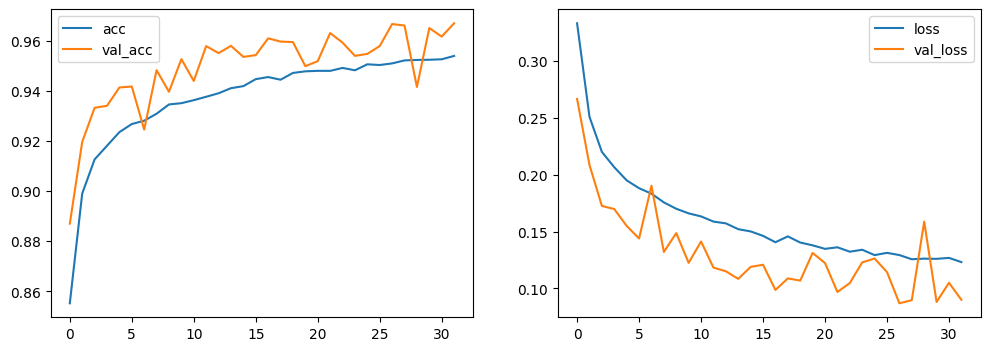

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='acc')
plt.plot(model_history.history['val_accuracy'], label='val_acc')
plt.legend()
# 2nd plot
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
test_loss, test_acc = model.evaluate(x_test_norm, y_test_bin)
print(f"Test accuracy: {test_acc*100:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9578 - loss: 0.1142
Test accuracy: 95.810
